In [1]:
from sklearn.cluster import KMeans,SpectralClustering
from sklearn.metrics import silhouette_samples, silhouette_score
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Definitions

This reads our genomic CSV file.

In [12]:
def csv2X(fname):
    mypd = pd.read_csv(fname, sep=',')
    ID = list(mypd)
    #X = np.transpose(mypd.values)
    X = mypd.values[:,1:]
    return X,ID

Given cluster labels, this outputs a CSV with patient IDs.

In [3]:
def patient_cluster(ID,cluster, fname):
   """
   input: csv file of patient id, numpy array of cluster membership
   output: csv file, first column: patient id; second column: cluster membership
   """
   p_c = list(zip(ID, cluster))
   new_df = pd.DataFrame()
   new_df['patient_id'] = ID
   new_df['cluster'] = cluster
   new_df.to_csv(fname,index=None)

There are two kinds of labelers: spectral clustering and K-means The former requires a similarity matrix. These each return a function that maps the number of clusters N to a vector of the labels.

In [4]:
def SClabeler(W):
    return lambda N: SpectralClustering(affinity='precomputed',n_clusters=N).fit_predict(W)
def KMlabeler():
    return lambda N: KMeans(n_clusters=N, init='random',n_init=10, max_iter=300,tol=1e-4).fit_predict(X)

This runs one labeler over a variety of cluster numbers, and makes silhouettes of each. See https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html.

In [5]:
def run_method(make_labels):
    n_clusters = range(2,8)
    fig,ax = plt.subplots(3,2)
    ax = ax.reshape(6)
    fig.set_size_inches(7, 9)

    for N in n_clusters:
        axi = N-2
        y_lower = 10    

        labels = make_labels(N)
        sil_values = silhouette_samples(X,labels)

        ax[axi].set_xlim([-0.1, 0.4])
        ax[axi].set_ylim([0, len(X) + (N + 1) * 10])

        for i in range(N):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            vi = sil_values[labels == i]
            vi.sort()

            Ni = vi.shape[0]
            y_upper = y_lower + Ni

            color = cm.nipy_spectral(float(i) / N)
            ax[axi].fill_betweenx(np.arange(y_lower, y_upper), 0, vi,
                              facecolor=color, edgecolor=color, alpha=0.7)

            ax[axi].text(-0.05, y_lower + 0.5 * Ni, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        # The vertical line for average silhouette score of all the values 
        ax[axi].set_title("{} clusters".format(N))
        silhouette_avg = silhouette_score(X,labels)
        ax[axi].axvline(x=silhouette_avg, color="red", linestyle="--")
        print('S score with {} clusters is {}'.format(N,silhouette_avg))
        print(np.histogram(labels,range(N+1))[0])
        ax[axi].set_yticks([])  # Clear the yaxis labels / ticks
        ax[axi].set_xticks([]);

    #ax.set_xlabel("Silhouette coefficient values")
    #ax.set_ylabel("Cluster label")
    ax[4].set_xticks([-0.1, 0, 0.2, 0.4]);
    ax[5].set_xticks([-0.1, 0, 0.2, 0.4]);
    plt.show()

# Read data

In [13]:
X,ID = csv2X("/Users/driscoll/Dropbox/research/hackathon19/datasets/training_pca_projs.csv")
print(X.shape)

(630, 1386)


# Spectral clustering (nearest neighbor similarity)

S score with 2 clusters is 0.08120511888648398
[377 257]
S score with 3 clusters is 0.06278794664391625
[232 245 157]
S score with 4 clusters is 0.06396501005179496
[229  74 174 157]
S score with 5 clusters is 0.05946160173662858
[ 92 211 157 100  74]
S score with 6 clusters is 0.06073084101607236
[210  99  91 115  44  75]
S score with 7 clusters is 0.03295178444722368
[108 117  74  44  91  85 115]


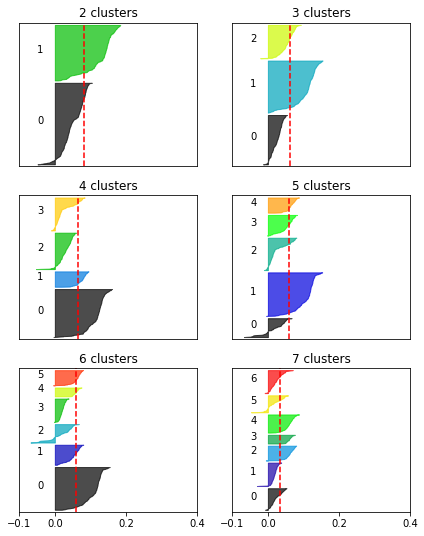

In [7]:
sc = SpectralClustering(affinity='nearest_neighbors',n_neighbors=80,n_clusters=2).fit(X);
Wnn = sc.affinity_matrix_
run_method(SClabeler(Wnn))

# Spectral clustering (RBF similarity)

S score with 2 clusters is 0.10038511500246636
[398 232]
S score with 3 clusters is 0.08501898763420733
[225 220 185]
S score with 4 clusters is 0.04909253535664089
[149 166 174 141]
S score with 5 clusters is 0.062130021100546204
[ 95 193 127  98 117]
S score with 6 clusters is 0.06695623031689119
[ 58 102  71 113 194  92]
S score with 7 clusters is 0.03700995625376741
[ 92  63 138  45 106  96  90]


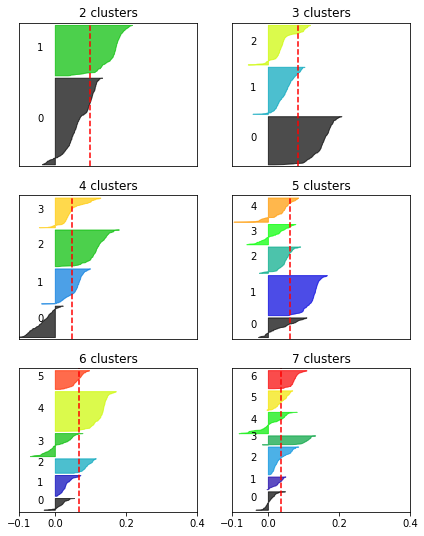

In [14]:
sc = SpectralClustering(affinity='rbf',gamma=5e-5,n_clusters=2).fit(X);
Wrbf = sc.affinity_matrix_
run_method(SClabeler(Wrbf))

# K-means clustering

S score with 2 clusters is 0.10030883345382083
[402 228]
S score with 3 clusters is 0.08539654572336809
[227 175 228]
S score with 4 clusters is 0.08135151816842134
[ 76 176 222 156]
S score with 5 clusters is 0.07892009624201393
[219 158  89  91  73]
S score with 6 clusters is 0.07828715426941076
[ 44  89 219  73  91 114]
S score with 7 clusters is 0.04219860315479922
[ 44  73 114  73 108 111 107]


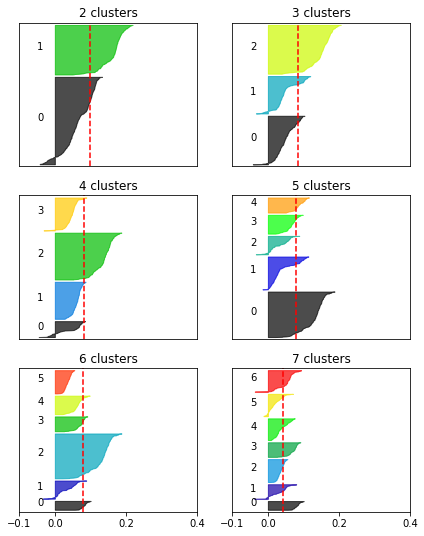

In [15]:
run_method(KMlabeler())

In [11]:
for N in range(2,6):
    labels = SClabeler(Wrbf)(N)
    patient_cluster(ID, labels, "patient_cluster_{}_rbf.csv".format(N))

In [17]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import umap
from sklearn.datasets import load_iris


In [18]:
def vis_umap(X, y_km):
    """
    visualize by UMAP
    """
    reducer = umap.UMAP()
    X_embedded = reducer.fit_transform(X)
    sns.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_km, legend='full', palette="Set1")
    plt.title('Visualized by UMAP')
    plt.show()


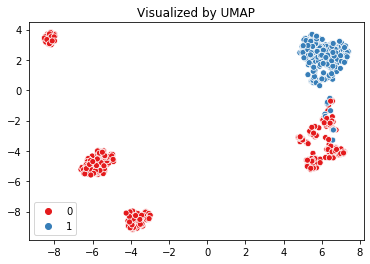

In [22]:
labels = SClabeler(Wrbf)(2)
vis_umap(X,labels)

In [23]:
?sns.scatterplot

Signature:
sns.scatterplot(
    x=None,
    y=None,
    hue=None,
    style=None,
    size=None,
    data=None,
    palette=None,
    hue_order=None,
    hue_norm=None,
    sizes=None,
    size_order=None,
    size_norm=None,
    markers=True,
    style_order=None,
    x_bins=None,
    y_bins=None,
    units=None,
    estimator=None,
    ci=95,
    n_boot=1000,
    alpha='auto',
    x_jitter=None,
    y_jitter=None,
    legend='brief',
    ax=None,
    **kwargs,
)
Docstring:
Draw a scatter plot with possibility of several semantic groupings.

The relationship between ``x`` and ``y`` can be shown for different subsets
of the data using the ``hue``, ``size``, and ``style`` parameters. These
parameters control what visual semantics are used to identify the different
subsets. It is possible to show up to three dimensions independently by
using all three semantic types, but this style of plot can be hard to
interpret and is often ineffective. Using redundant semantics (i.e. both
``hue`` and

In [24]:
?plt.scatter

Signature:
plt.scatter(
    x,
    y,
    s=None,
    c=None,
    marker=None,
    cmap=None,
    norm=None,
    vmin=None,
    vmax=None,
    alpha=None,
    linewidths=None,
    verts=None,
    edgecolors=None,
    *,
    plotnonfinite=False,
    data=None,
    **kwargs,
)
Docstring:
A scatter plot of *y* vs *x* with varying marker size and/or color.

Parameters
----------
x, y : array_like, shape (n, )
    The data positions.

s : scalar or array_like, shape (n, ), optional
    The marker size in points**2.
    Default is ``rcParams['lines.markersize'] ** 2``.

c : color, sequence, or sequence of color, optional
    The marker color. Possible values:

    - A single color format string.
    - A sequence of color specifications of length n.
    - A sequence of n numbers to be mapped to colors using *cmap* and
      *norm*.
    - A 2-D array in which the rows are RGB or RGBA.

    Note that *c* should not be a single numeric RGB or RGBA sequence
    because that is indistinguishable f